# IMPLEMENTACIÓN REDES NEURONALES
Se trabaja con los datos del archivo "spotify_churn_dataset.csv". En el hay informacion sobre el uso de los usuarios de la aplicacion Spotify (8000 usuarios) junto con informacion de los propios usuarios.
El objetivo es tratar de encontrar una relación entre los datos de los que disponemos y gracias a esa relación, crear un modelo que prediga una columna clase.

Nuestro modelo de redes neuronales contará de 3 capas. Más adelante se concretarán el numero de neuronas por capa.

In [1]:
import numpy as np
import pandas as pd
import scipy.optimize as opt
import random
import matplotlib.pyplot as plt

En primer lugar, se cargaran los datos de entrada del fichero "spotify_churn_dataset.csv". Dicho fichero tiene 12 columnas y 8000 filas.

In [2]:
def read_file(file_name):
    
    file = pd.read_csv(file_name)
    # names=["user_id","gender","age","country","subscription_type","listening_time","songs_played_per_day","skip_rate","device_type","ads_listened_per_week","offline_listening","is_churned"]

    return file

In [3]:
file = read_file('spotify_churn_dataset.csv')
print("Tamaño del csv:",file.shape)

Tamaño del csv: (8000, 12)


## Exploración de los datos
El dataset fue explorado en su totalidad en la implementación de la regresión lineal, por lo que no se volverá a explorar aqui. Si se recordarán los puntos mas importantes, como son:

- El dataset no incluye ninguna columna con una relación con otra que ofrezca un gran valor para la creaciones de modelos, por lo que se opta por modelos multivariables.

- Incluso en modelos multivariables, se pudo comprobar que la implementación no es capaz de sacar un modelo robusto que ofrezca buenas predicciones, en lugar de eso tiende a la media para minimizar el error.

- Se corroboró que el problema era del dataset, ya que se probó la misma implementación en otro dataset de prueba y el modelo se generó correctamente.

Teniendo esto en cuenta, se recuerda que lo mas probable es que en esta implementación suceda algo similar y si se llegará a encontrar unas columnas que se salieran de lo dicho, se explicaría el porque de su buen funcionamiento

## Implementación del modelo
Tras tener las consideraciones previas en mente, se buscarán unas columnas que puedan ofrecer un buen resultado (o al menos alguno distinto a la media).
Se podría utilizar de clase el tipo de subscripción, pero me temo que solo acertará el modelo cuando la subscripcion sea gratuita (porque los anuncios serán 0). Se podría probar también por el genero, aunque no encuentro ninguna columna con razón aparente con la que tuviera alguna relación oculta. 

### Inicializacion de los parametros
Se va a terminar prediciendo la columna "is_churned", por el interes que puede suponer poder predecir que usuarios podrían dejar de usar la aplicación. Se utilizará para predecirlo las columnas "listening_time", "songs_played_per_day" y "ads_listened_per_week", ya que podria verse una relacion entre el uso (tiempo de escucha y canciones escuchadas) y la permanencia de una persona o incluso de los anuncios que escucha, ya que podrían darse el caso de que rechacen el servicio por la cantidad de anuncios.

In [4]:
X = pd.DataFrame({
    #"user_id":file["user_id"]
    
    #,"Female":gender["Female"]
    #,"Male":gender["Male"]
    #,"Other":gender["Other"]
    
    #,"age":file["age"]
    
    #,"AU":country["AU"]
    #,"CA":country["CA"]
    #,"DE":country["DE"]
    #,"FR":country["FR"]
    #,"IN":country["IN"]
    #,"PK":country["PK"]
    #,"UK":country["UK"]
    #,"US":country["US"]
    
    #,"Family":subscription_type["Family"]
    #,"Free":subscription_type["Free"]
    #,"Premium":subscription_type["Premium"]
    #,"Student":subscription_type["Student"]
    
    "listening_time":file["listening_time"]
    ,"songs_played_per_day":file["songs_played_per_day"]
    #,"skip_rate":file["skip_rate"]
    
    #,"Desktop":device_type["Desktop"]
    #,"Mobile":device_type["Mobile"]
    #,"Web":device_type["Web"]
    
    ,"ads_listened_per_week":file["ads_listened_per_week"]
    #,"offline_listening":file["offline_listening"]
    #,"is_churned":file["is_churned"]               
                 })
y = file["is_churned"]

### Creación de funciones

##### Creacion de funciones necesarias (1)
Funciones propias de las redes neuronales

In [5]:
# Funcion sigmoide
def sigmoid(z):
  return 1 / (1+np.exp(-z))

# Funcion forward que dados las 2 matrices thethas, X y la fila actual (i) calcula a1, a2 y a3 
def forward(theta1, theta2, X, i):
  # bias (columna de 1) + neuronas de la capa 1
  a1 = np.hstack((np.ones(1), X.iloc[i])) # Igual que: ones = np.ones(1)  a1 = np.hstack((ones, X[i]))

  a2 = sigmoid(theta1 @ a1 )
  # bias + neuronas de la capa 2
  a2 = np.hstack((1, a2)) # Igual que: a2 = np.hstack((ones, a2))
  
  # a3 es la salida de la capa 3 o hipótesis (h)
  a3 = sigmoid(theta2 @ a2)
  return a1, a2, a3


# Función coste sin regularizar
def nnCostFunction(nn_params, input_layer_size, hidden_layer_size, num_labels, X, y):
  # Se enrolla nn_params, el cual tenia desenrollados theta1 y theta2.
  theta1 = np.reshape(nn_params[:hidden_layer_size*(input_layer_size+1)], # datos 
                      (hidden_layer_size, input_layer_size+1), # nueva shape: (hidden_layer_size, input_layer_size+1)
                      'F') # El order debe ser el mismo que cuando desenrollemos
  theta2 = np.reshape(nn_params[hidden_layer_size*(input_layer_size+1):], (num_labels, hidden_layer_size+1), 'F')
  
  m = len(y) 
  suma = 0 
  y_d = pd.DataFrame(y) 

  # Para cada fila se calcula el coste al igual que en la regresion logistica 
  for i in range(X.shape[0]):
      a1, a2, h = forward(theta1, theta2, X, i)
      
      temp1 = y_d.iloc[i] * (np.log(h)) 
      temp2 = (1 - y_d.iloc[i]) * np.log(1 - h) 
      temp3 = np.sum(temp1 + temp2) 
      
      suma = suma + temp3
  J = (np.sum(suma) / (-m))
  return J


def nnGradFunction(nn_params, input_layer_size, hidden_layer_size, num_labels, X, y):
  # Se enrolla nn_params, el cual tenia desenrollados theta1 y theta2.
  initial_theta1 = np.reshape(nn_params[:hidden_layer_size * (input_layer_size + 1)], (hidden_layer_size, input_layer_size + 1), 'F')
  initial_theta2 = np.reshape(nn_params[hidden_layer_size * (input_layer_size + 1):], (num_labels, hidden_layer_size + 1), 'F')
  
  m = len(y)
  y_d = pd.DataFrame(y)
  delta1 = np.zeros(initial_theta1.shape) # Tiene las mismas dimensiones que theta1
  delta2 = np.zeros(initial_theta2.shape) # Tiene las mismas dimensiones que theta2

  # Para cada fila, se calcula el delta o el error cometido y 
  for i in range(X.shape[0]):
      a1, a2, a3 = forward(initial_theta1, initial_theta2, X, i)
      
      
      d3 = a3 - y_d.iloc[i] # Capa 3 
      d2 = np.multiply(np.dot(initial_theta2.T,d3), np.multiply(a2, 1-a2)) # Capa 2
      # La capa 1 no produce errores (son los datos de entrada)
      
      delta1 = delta1 + (  np.reshape(d2[1:,],(hidden_layer_size, 1) ) @ np.reshape(a1, (1, input_layer_size+1) )  )
      delta2 = delta2 + (  np.reshape(d3.values, (num_labels, 1) ) @ np.reshape(a2, (1, hidden_layer_size+1) )  )

  # Se hace la media y se desenrollan las delta en el mismo orden que estaban desenrolladas las theta
  delta1 /= m
  delta2 /= m
  gradiente = np.hstack(( delta1.ravel(order='F'), delta2.ravel(order='F') ))
  return gradiente

##### Creacion de funciones necesarias (2)
Funciones para la generación del modelo

In [6]:
def training(initial_theta1, initial_theta2, X_train, y_train, input_layer_size, hidden_layer_size, num_labels):
  # Se deja a iteracion 1 por defecto, ya que se ha probado con 10 iteraciones y el resultado es muy similar o identico a una iteración y el tiempo de computo es grande.
  #maxiter = 10
  maxiter = 1

  # Paso 1: Desenrollar los parámetros con el mismo order con el que se enrollaron
  nn_initial_params = np.hstack((initial_theta1.ravel(order='F'), initial_theta2.ravel(order='F')))

  # Paso 2: Llamada al optimizador avanzado gradiente conjugado con la función: fmin_cg
  nn_params = opt.fmin_cg(maxiter=maxiter, f=nnCostFunction, x0=nn_initial_params, fprime=nnGradFunction,
                        args=(input_layer_size, hidden_layer_size, num_labels, X_train, y_train))
  
  # Paso 3: Enrollar los pesos/parámetros theta1 y theta2 desde la salida del optimizador avanzado (nn_params)
  theta1 = np.reshape(nn_params[:hidden_layer_size * (input_layer_size + 1)],
                      (hidden_layer_size, input_layer_size + 1), order = 'F')
  theta2 = np.reshape(nn_params[hidden_layer_size * (input_layer_size + 1):], 
                      (num_labels, hidden_layer_size + 1), order = 'F')
  return theta1, theta2


def predict(theta1, theta2, X):
  # Variables útiles
  m = len(X)
  ones = np.ones((m,1))

  a1 = np.hstack((ones, X))
  a2 = sigmoid(a1 @ theta1.T)
  a2 = np.hstack((ones, a2))
  h = sigmoid(a2 @ theta2.T) # La hipótesis o predicción 

  pred = np.where(h >= 0.5, 1, 0)
  return pred


# COMPLETAR
def randInitializeWeights(L_in, L_out):

  # Se va a inicializar W de manera random para "romper" la simetría mientras se entrena la red neuronal
  epsilon_init = 0.12 # Se define un epsilon
  W = np.random.rand(L_out, 1+L_in) * (2 * epsilon_init) - epsilon_init
  return W
    

# COMPLETAR
def optimalHiddenNeurons(input_layer_size, num_labels, X_train, y_train, X_val, y_val):
  # Paso 1: # Inicializamos variables útiles
  num_max_neuronas = 10 # el número máximo de neuronas en el grid
  print('\nCalculando número óptimo de neuronas de la capa oculta... \n')
  print('\nNúmero máximo de neuronas: ',num_max_neuronas)

  arr_accuracy = [] # Inicializamos la lista donde almacenaremos la precisión del conjunto de 
  # validación para los diferentes números de neuronas del grid

  # Paso 2: Bucle desde 1 hasta num_max_neuronas (incluido, por eso el +1)
  for hidden_layer_size in range(1, num_max_neuronas+1):
    print('-----\nNúmero de neuronas de la capa oculta: ',hidden_layer_size)

    # Paso 2.1: Inicializar los pesos aleatoriamente con las dimensiones correctas
    initial_theta1 = randInitializeWeights(input_layer_size, hidden_layer_size)
    initial_theta2 = randInitializeWeights(hidden_layer_size, num_labels)

    # Paso 2.2: Entrenamiento de la red neuronal con el número de neuronas de la capa oculta
    theta1_opt, theta2_opt = training(initial_theta1, initial_theta2, X_train, y_train, input_layer_size, hidden_layer_size, num_labels)

    # Paso 2.3: Predicción usando el conjunto de validación
    pred = predict(theta1_opt, theta2_opt, X_val)
      
    # Paso 2.4: Calcular la precisión/accuracy máxima
    print("accuracy: ", np.mean(pred== y_val.flatten()) * 100 )
    arr_accuracy.append(np.mean(pred== y_val.flatten()) * 100 ) # Se añade a la lista de precisión
    
    
  # Paso 3: Fuera del bucle, encontrar el número de neuronas ocultas con las que se consigue el mejor accuracy
  optimal_hidden_layer_size = np.argmax(arr_accuracy)+1 # +1 porque np.argmax() nos proporciona la posición en la lista del mejor valor. Las posiciones empiezan en 0 y nosotros empezamos en 1 neurona
  print("\n**** El número de neuronas de la capa oculta óptimo es: ", optimal_hidden_layer_size)
  print("**** Con esas neuronas en la capa oculta, el accuracy del conjunto de validación es: ", max(arr_accuracy))

  return optimal_hidden_layer_size

##### Creacion de funciones necesarias (3)
Funciones de utilidad

In [7]:
def generaTrainTest(X, y, tamTest = 0.3):
    
    listaTest = []
    listaTrain = []
    i = 0
    tamanyo = int(len(y) * tamTest)
    print("Tamanyo train = " + str(X.shape[0] - tamanyo))
    print("Tamanyo test = " + str(tamanyo))
    while i < tamanyo:
        numero = int(random.random() * len(y))
        if numero not in listaTest:
            listaTest.append(numero)
            i += 1

    for i in range(len(y)):
        if i not in listaTest:
            listaTrain.append(i)

    X_train = X.iloc[listaTrain ]
    y_train = y.iloc[listaTrain]
    
    X_test = X.iloc[listaTest ]
    y_test = y.iloc[ listaTest ]
    return X_train, y_train, X_test, y_test

def normalize(X):
    mu = X.mean()
    sigma = X.std()
    X_norm = pd.DataFrame((X - mu)/(sigma))
    return X_norm

def muestraResultados(theta1, theta2, X, y, limit):
    pred = predict(theta1, theta2, X)
        
    plt.scatter(range(len(y)), pred, c="red", marker="x", label="Predicho")
    plt.scatter(range(len(y)), y, c="blue", marker=".", label="Real")

    plt.xlabel("Usuario")
    plt.ylabel("Abandona")

    plt.grid(True)

    plt.xlim(0, limit)
    
    plt.legend()
    plt.show()

def plotDiferencias(theta1, theta2, X, y):    
    sigm = []
    sigm2 = []
    prec = []
    prec2 = []

    pred = predict(theta1, theta2, X )
    for i in range(len(pred)):
        valor = pred[i]
        valor = valor[0]
        valor2 = y[i]
        
    plt.scatter(prec, sigm, c="blue", marker=".", label="Acierta")
    plt.scatter(prec2, sigm2, c="red", marker="x", label="Falla")

    plt.xlabel("Predecido")
    plt.ylabel("Sigmoide")

    plt.legend()
    plt.show()   

### Fase de entrenamiento Y Evolución de la función de coste
En primera instancia, se recogen los datos del problema concreto (numero de neuronas en la capa de entrada y de salida, como en este caso la salida es binaria, solo se necesita una neurona). 

In [8]:
input_layer_size = X.shape[1] # Número de columnas de los datos de entrada (X)
num_labels = 1 # Sigue usando Spotify/No usa Spotify

Posteriormente, tenemos que separar nuestro conjunto de datos en entrenamiento y test para que, cuando el modelo esté entrenado, se pruebe con un conjunto distinto al que se entrenó. También, a partir del conjunto de entrenamiento general, se calcularán 2 subconjuntos (entrenamiento y validación), con los cuales se entrenará y se comprobará el modelo a lo largo del entrenamiento.

In [9]:
# Calcular el conjunto de entrenamiento y el de test. 70% train, 30% test
print(f"Train general y test general. Tamanyo General: {X.shape[0]}")
X_trainGen, y_trainGen, X_testGen, y_testGen = generaTrainTest(X, y)

# De el conjunto de entrenamiento, generar el de validacion y el de entrenamiento. El 70% train se subdivide en: 70% train, 30% val
print(f"\nTrain y validacion. Tamanyo Train general: {X_trainGen.shape[0]}")
X_train, y_train, X_val, y_val = generaTrainTest(X_trainGen, y_trainGen) 

Train general y test general. Tamanyo General: 8000
Tamanyo train = 5600
Tamanyo test = 2400

Train y validacion. Tamanyo Train general: 5600
Tamanyo train = 3920
Tamanyo test = 1680


In [10]:
# Para evitar errores, convertimos a numpy array las y
y_testGen = y_testGen.to_numpy()
y_train = y_train.to_numpy()
y_val = y_val.to_numpy()

Se normalizan el conjunto de entrenamiento y el de validación y se calculan las neuronas optimas para la capa oculta.

In [11]:
X_train_Norm = normalize(X_train)
X_val_Norm = normalize(X_val)
optimal_hidden_layer_size = optimalHiddenNeurons(input_layer_size, num_labels, X_train_Norm, y_train, X_val_Norm, y_val) # Se pasan: el numero de neuronas de la primera y tercera capa, 
# X de entrenamiento normalizado e y de entrenamiento y X de validacion normalizado e y de validacion.


Calculando número óptimo de neuronas de la capa oculta... 


Número máximo de neuronas:  10
-----
Número de neuronas de la capa oculta:  1


C:\Users\Emilio\anaconda3\Lib\site-packages\scipy\optimize\_optimize.py:1680: OptimizeWarning: Maximum number of iterations has been exceeded.
  res = _minimize_cg(f, x0, args, fprime, callback=callback, c1=c1, c2=c2,


         Current function value: 0.578833
         Iterations: 1
         Function evaluations: 3
         Gradient evaluations: 3
accuracy:  74.52380952380952
-----
Número de neuronas de la capa oculta:  2


C:\Users\Emilio\anaconda3\Lib\site-packages\scipy\optimize\_optimize.py:1680: OptimizeWarning: Maximum number of iterations has been exceeded.
  res = _minimize_cg(f, x0, args, fprime, callback=callback, c1=c1, c2=c2,


         Current function value: 0.578790
         Iterations: 1
         Function evaluations: 3
         Gradient evaluations: 3
accuracy:  74.52380952380952
-----
Número de neuronas de la capa oculta:  3


C:\Users\Emilio\anaconda3\Lib\site-packages\scipy\optimize\_optimize.py:1680: OptimizeWarning: Maximum number of iterations has been exceeded.
  res = _minimize_cg(f, x0, args, fprime, callback=callback, c1=c1, c2=c2,


         Current function value: 0.578655
         Iterations: 1
         Function evaluations: 3
         Gradient evaluations: 3
accuracy:  74.52380952380952
-----
Número de neuronas de la capa oculta:  4


C:\Users\Emilio\anaconda3\Lib\site-packages\scipy\optimize\_optimize.py:1680: OptimizeWarning: Maximum number of iterations has been exceeded.
  res = _minimize_cg(f, x0, args, fprime, callback=callback, c1=c1, c2=c2,


         Current function value: 0.578611
         Iterations: 1
         Function evaluations: 3
         Gradient evaluations: 3
accuracy:  74.52380952380952
-----
Número de neuronas de la capa oculta:  5


C:\Users\Emilio\anaconda3\Lib\site-packages\scipy\optimize\_optimize.py:1680: OptimizeWarning: Maximum number of iterations has been exceeded.
  res = _minimize_cg(f, x0, args, fprime, callback=callback, c1=c1, c2=c2,


         Current function value: 0.578723
         Iterations: 1
         Function evaluations: 3
         Gradient evaluations: 3
accuracy:  74.52380952380952
-----
Número de neuronas de la capa oculta:  6


C:\Users\Emilio\anaconda3\Lib\site-packages\scipy\optimize\_optimize.py:1680: OptimizeWarning: Maximum number of iterations has been exceeded.
  res = _minimize_cg(f, x0, args, fprime, callback=callback, c1=c1, c2=c2,


         Current function value: 0.598419
         Iterations: 1
         Function evaluations: 2
         Gradient evaluations: 2
accuracy:  74.52380952380952
-----
Número de neuronas de la capa oculta:  7


C:\Users\Emilio\anaconda3\Lib\site-packages\scipy\optimize\_optimize.py:1680: OptimizeWarning: Maximum number of iterations has been exceeded.
  res = _minimize_cg(f, x0, args, fprime, callback=callback, c1=c1, c2=c2,


         Current function value: 0.601217
         Iterations: 1
         Function evaluations: 2
         Gradient evaluations: 2
accuracy:  74.52380952380952
-----
Número de neuronas de la capa oculta:  8


C:\Users\Emilio\anaconda3\Lib\site-packages\scipy\optimize\_optimize.py:1680: OptimizeWarning: Maximum number of iterations has been exceeded.
  res = _minimize_cg(f, x0, args, fprime, callback=callback, c1=c1, c2=c2,


         Current function value: 0.593321
         Iterations: 1
         Function evaluations: 2
         Gradient evaluations: 2
accuracy:  74.52380952380952
-----
Número de neuronas de la capa oculta:  9


C:\Users\Emilio\anaconda3\Lib\site-packages\scipy\optimize\_optimize.py:1680: OptimizeWarning: Maximum number of iterations has been exceeded.
  res = _minimize_cg(f, x0, args, fprime, callback=callback, c1=c1, c2=c2,


         Current function value: 0.586060
         Iterations: 1
         Function evaluations: 2
         Gradient evaluations: 2
accuracy:  74.52380952380952
-----
Número de neuronas de la capa oculta:  10
         Current function value: 0.581969
         Iterations: 1
         Function evaluations: 2
         Gradient evaluations: 2
accuracy:  74.52380952380952

**** El número de neuronas de la capa oculta óptimo es:  1
**** Con esas neuronas en la capa oculta, el accuracy del conjunto de validación es:  74.52380952380952


C:\Users\Emilio\anaconda3\Lib\site-packages\scipy\optimize\_optimize.py:1680: OptimizeWarning: Maximum number of iterations has been exceeded.
  res = _minimize_cg(f, x0, args, fprime, callback=callback, c1=c1, c2=c2,


Se inicializan los thetas acordes al numero de neuronas de las tres capas y se entrenan con el conjunto de entrenamiento general.

In [12]:
initial_theta1 = randInitializeWeights(input_layer_size, optimal_hidden_layer_size)
initial_theta2 = randInitializeWeights(optimal_hidden_layer_size, num_labels)

X_trainGen_Norm = normalize(X_trainGen)
theta1_opt, theta2_opt = training(initial_theta1, initial_theta2, X_trainGen_Norm, y_trainGen, input_layer_size, optimal_hidden_layer_size, num_labels) # Se pasan: los 2 thetas iniciales, 
# X de entrenamiento general normalizado e y de entrenamiento general y el numero de neuronas de la primera y tercera capa.

         Current function value: 0.575606
         Iterations: 1
         Function evaluations: 3
         Gradient evaluations: 3


C:\Users\Emilio\anaconda3\Lib\site-packages\scipy\optimize\_optimize.py:1680: OptimizeWarning: Maximum number of iterations has been exceeded.
  res = _minimize_cg(f, x0, args, fprime, callback=callback, c1=c1, c2=c2,


### Fase de predicción Y Métrica de evaluación apropiada.
Por ultimo, se predice usando el conjunto de test y se compara con la clase para calcular el error cometido.

In [13]:
X_testGen_Norm = normalize(X_testGen)
pred = predict(theta1_opt, theta2_opt, X_testGen_Norm)
print("Accuracy del conjunto de test: ", np.mean(pred== y_testGen.flatten()) * 100) # Calcular la precisión viendo cuantas veces coinciden los valores reales y los predichos.

Accuracy del conjunto de test:  74.875


Pudiera parecer un buen resultado, ya que el 74% de las veces el modelo acierta incluso en unos datos que no ha tocado, sin embargo conocemos el conjunto de datos y sabemos que las columnas no tienen relación aparente entre ellas (se ha demostrado en la regresión lineal). Por lo tanto, se pinta una gráfica para observar que está ocurriendo con las predicciones.

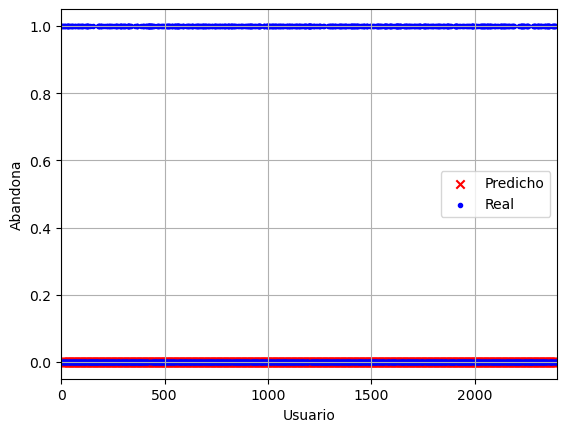

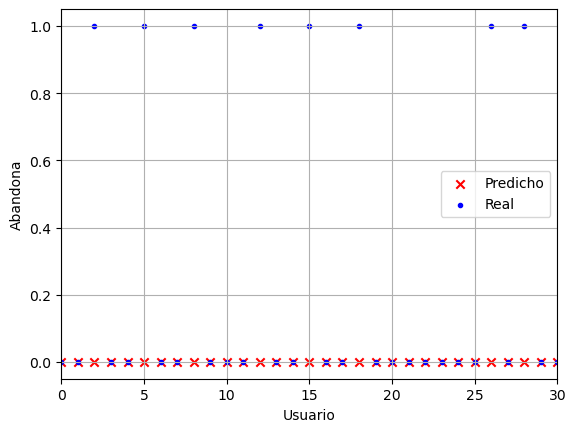

In [14]:
# El ultimo parametro de la función indica el limite de visualización del eje X

# Pintado de azul, los valores reales para los distintos usuarios de la columna is_churned
# Pintado de rojo, los valores predichos para los distintos usuarios de la columna is_churned

muestraResultados(theta1_opt, theta2_opt, X_testGen, y_testGen, len(y_testGen))
muestraResultados(theta1_opt, theta2_opt, X_testGen, y_testGen, 30) 

#### ¿Que es lo que ocurre?
Como ya se comentó a lo largo de este trabajo, las columnas no parecen tener ningun tipo de relación. Ante este caso, el modelo, que está entrenado para minimizar los fallos, opta por predecir siempre el valor que sea mas recurrente, en este caso el valor de 0. Por eso se puede ver en la celda anterior, en la primera grafica, que solo hay puntos rojos en la posición 0 del eje y.

Se puede demostrar de una manera muy sencilla que el modelo predice siempre 0. Para esto, vamos a predecir is_churned para todo el conjunto de datos, posteriormente, contaremos el numero de veces que se predice 0 y se compará con el tamaño total del conjunto. Si estamos en lo correcto, el numero de filas del conjunto tiene que ser igual a las veces que se predice como 0.

In [15]:
pred = predict(theta1_opt, theta2_opt, X)
is_cero = 0
for value in pred:
    value = value[0]
    if(value == 0):
        is_cero += 1
print(f"Numero de veces que se ha predicho 0 en un conjunto de {X.shape[0]} filas: {is_cero} veces.")

Numero de veces que se ha predicho 0 en un conjunto de 8000 filas: 8000 veces.
